In [1]:
import os

import torch
import torchvision
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import numpy as np

from field_classifier import do_train, YoloClsDataset, ResizeByLarger, SquarePad, MobileNetV3Classifier, make_transforms


e:\IT\pet\airport-boardgame-detection\venv_win\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def imread_torch(filepath):
    "# uint 0..255"
    return torchvision.io.read_image(filepath)

def imshow_torch(img, figsize=(4, 4)):
    img = img.detach().cpu().numpy()
    img = img.transpose((1, 2, 0))

    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

def imshow_torch_batch(images, titles):
    assert len(images) == len(titles)

    max_ncols = 8
    nimgs = len(images)
    ncols = min(nimgs, max_ncols)
    nrows = nimgs // max_ncols + bool(nimgs % max_ncols)

    plt.figure(figsize=(2 * ncols, 2 * nrows))

    for index in range(nimgs):
        i = index // ncols
        j = index - i * ncols
    
        index = i * ncols + j
        image = images[index]
        title = titles[index]

        image_np = image.detach().cpu().numpy()
        image_np = image_np.transpose((1, 2, 0))

        plt.subplot(nrows, ncols, 1 + index)
        plt.title(title)
        plt.axis('off')

        plt.imshow(image_np, aspect='auto')
    plt.subplots_adjust(hspace=0.2, wspace=0.02)
    plt.show()


In [129]:
int(torch.randint(0, 10 - 5 + 1, size=(1,)))

5

In [80]:
# torch.randint?

In [229]:
class PickRandomRect(torch.nn.Module):
    def __init__(self, size=96, fill=255):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        c, h, w = img.shape
        assert c == 3
        assert w - self.size + 1 > 0
        assert h - self.size + 1 > 0

        x1 = int(torch.randint(0, w - self.size + 1, size=(1,)))
        y1 = int(torch.randint(0, h - self.size + 1, size=(1,)))
        x2 = int(torch.randint(0, w - self.size + 1, size=(1,)))
        y2 = int(torch.randint(0, h - self.size + 1, size=(1,)))

        result = torch.full_like(img, fill_value=self.fill)
        result[:, y1:y1+self.size, x1:x1+self.size] = \
            img[:, y2:y2+self.size, x2:x2+self.size]

        return result

In [283]:
from field_classifier import RandomHorizontalFlipLabel, RandomVerticalFlipLabel, RandomRotateLabel, ImageOnlyTransform
from torchvision.transforms import v2


def make_transform(train=True):
    imgsz = 128

    pre_augmentations = [
        ResizeByLarger(2 * imgsz),
    ]
    augmentations = [
        v2.ColorJitter(brightness=0.4, contrast=0.1, saturation=0.1, hue=0.05),
        v2.RandomZoomOut(255, (1, 1.1), p=0.5),
        # v2.RandomRotation((-5, 5), fill=255),

        PickRandomRect(imgsz // 2 * 2, fill=0)
    ]
    augmentations_label = [
        RandomHorizontalFlipLabel({}),
        RandomVerticalFlipLabel({}),
        RandomRotateLabel({}),
    ]
    post_augmentations = [
        SquarePad(255),
        v2.Resize(imgsz),
        v2.ToDtype(torch.float32, scale=True),
    ]

    pre_augmentations = [ImageOnlyTransform(t) for t in pre_augmentations]
    augmentations = [ImageOnlyTransform(t) for t in augmentations]
    post_augmentations = [ImageOnlyTransform(t) for t in post_augmentations]

    transforms_list = pre_augmentations.copy()
    if train:
        transforms_list.extend(augmentations)
        transforms_list.extend(augmentations_label)
    transforms_list.extend(post_augmentations)

    transform = v2.Compose(transforms_list)
    return transform


def make_transforms():
    train_transform = make_transform(train=True)
    val_transform = make_transform(train=False)
    return train_transform, val_transform


train_transform, val_transform = make_transforms()

In [284]:
working_directory = '.'
dataset_path = os.path.join(working_directory, '../../data/datasets/field-classification-tv')

train_dataset = YoloClsDataset(dataset_path, train=True, transform=train_transform, load_only_classes=False)
val_dataset = YoloClsDataset(dataset_path, train=False, transform=val_transform, load_only_classes=False)

unique_labels = train_dataset.unique_labels
print(unique_labels)


['expert', 'junior', 'master', 'starter']


0 expert


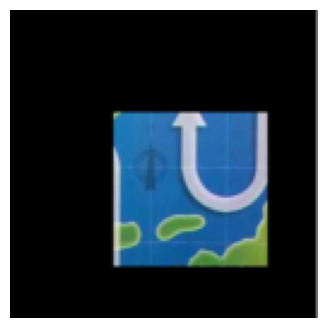

In [341]:
image, label = train_dataset[0]
# image, label = val_dataset[6]

print(label, unique_labels[label])

imshow_torch(image, figsize=(4, 4))


In [27]:
image.shape

torch.Size([3, 128, 128])

In [342]:
classifier = MobileNetV3Classifier('runs/05/best.pt', ['expert', 'junior', 'master', 'starter'])

['expert', 'expert', 'junior', 'junior', 'master', 'master', 'starter', 'starter']
['expert', 'expert', 'master', 'master', 'master', 'master', 'starter', 'starter']


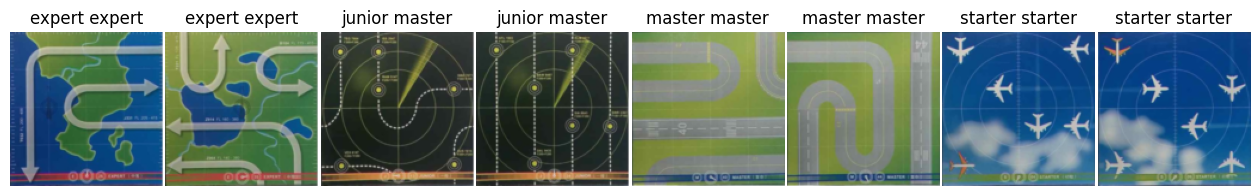

In [343]:
images, np_images, labels = [], [], []
for i, (image, label) in enumerate(val_dataset):
    np_image = image.numpy().transpose((1, 2, 0)).copy()
    np_image *= 255
    np_image = np_image.round().astype(np.uint8)
    
    images.append(image)
    np_images.append(np_image)
    labels.append(label)

labels = list(map(unique_labels.__getitem__, labels))
preds = classifier.predict(np_images)

print(labels)
print(preds)

imshow_torch_batch(images, [f'{l} {p}' for l, p in zip(labels, preds)])

# for image in images:
#     imshow_torch(image, figsize=(1, 1))
    

In [220]:


image, label = val_dataset[1]
np_image = image.numpy().transpose((1, 2, 0))
np_image *= 255
np_image = np_image.round().astype(np.uint8)

classifier.predict([np_image])

['expert']